<a href="https://colab.research.google.com/github/Nathtaba/Case_Problemas_Ortopedicos_Classifier_ML/blob/main/Classificando_problemas_ortopedicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
from sklearn.datasets import fetch_openml #importando o open ML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV #metodo para seleção dos melhores Ks (#Basicamente a busca por força bruta)
from sklearn.metrics import make_scorer, accuracy_score, f1_score #métricas de validação

In [24]:
dados = fetch_openml(data_id=1523)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [25]:
tabela_dados = pd.DataFrame(data=dados['data'])

In [26]:
tabela_dados.head()

,V1,V2,V3,V4,V5,V6
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985136,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


Passo 1: Transformando a base de dados:

In [27]:
classes = {'1':'Disk Hernia',
           '2':'Normal',
           '3':'Spondylolisthesis'}

In [28]:
classes['1'], classes['2'], classes['3']

('Disk Hernia', 'Normal', 'Spondylolisthesis')

In [29]:
tabela_dados['diagnostic'] = [classes[target] for target in dados.target]

In [30]:
tabela_dados

,V1,V2,V3,V4,V5,V6,diagnostic
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Disk Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Disk Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985136,-3.530317,Disk Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Disk Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Disk Hernia
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,Normal


Passo 2: Análise exploratória dos dados

In [31]:
tabela_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   V1          310 non-null    float64
 1   V2          310 non-null    float64
 2   V3          310 non-null    float64
 3   V4          310 non-null    float64
 4   V5          310 non-null    float64
 5   V6          310 non-null    float64
 6   diagnostic  310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [32]:
len(tabela_dados)

310

In [33]:
tabela_dados.describe()

,V1,V2,V3,V4,V5,V6
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767933
75%,72.877696,22.120395,63.000000,52.695889,125.467675,41.287352
max,129.834041,49.431864,125.742386,121.429566,163.071041,418.543082


In [34]:
tabela_dados.groupby('diagnostic').mean()

,V1,V2,V3,V4,V5,V6
diagnostic,,,,,,
Disk Hernia,47.638407,17.398795,35.463524,30.239612,116.474968,2.480251
Normal,51.685244,12.821414,43.542605,38.863830,123.890834,2.186572
Spondylolisthesis,71.514224,20.748038,64.110108,50.766186,114.518810,51.896687


In [35]:
#Analisando o outlier na coluna V6 da linha com o valor maior que 400:
tabela_dados.loc[tabela_dados['V6'] > 400]

,V1,V2,V3,V4,V5,V6,diagnostic
115,129.834041,8.404475,48.384057,121.429566,107.690466,418.543082,Spondylolisthesis


<Axes: xlabel='V6', ylabel='Count'>

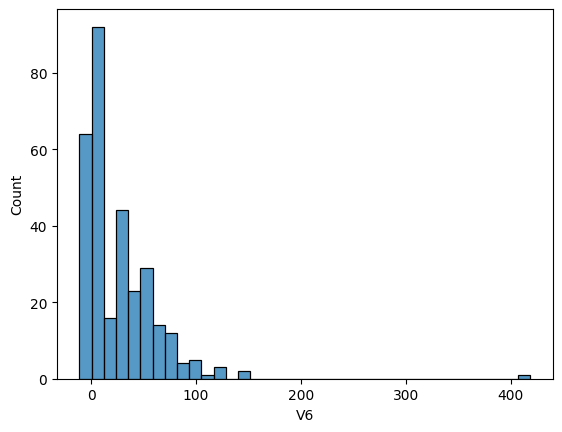

In [36]:
sns.histplot(data=tabela_dados, x='V6')

<Axes: ylabel='V6'>

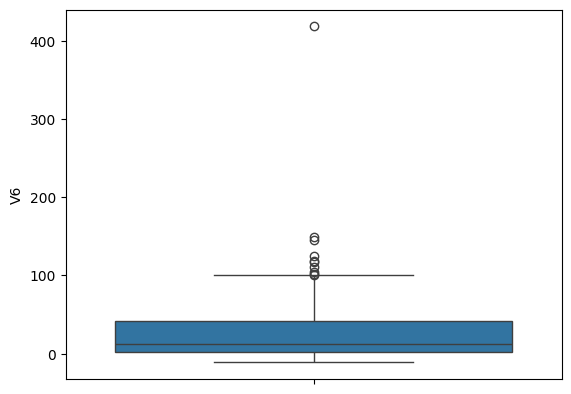

In [38]:
sns.boxplot(data=tabela_dados, y='V6')

In [39]:
#Removendo o outlier
tabela_dados.drop(tabela_dados.loc[tabela_dados['V6'] > 400].index, inplace=True)


Passo 3: Separação dos dados

In [41]:
X = tabela_dados.drop(columns=['diagnostic'])
y = tabela_dados['diagnostic'] #(Target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Passo 4: Normalizando os dados

In [42]:
#scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)
scaler = MinMaxScaler() #chamando o metodo de normalização dos dados (0-1)

scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_test_scaled= scaler.transform(X_test)


Passo 5: Criação do modelo

In [43]:
modelo_classificador = KNeighborsClassifier(n_neighbors=3)

modelo_classificador.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [73]:
y_predit = modelo_classificador.predict(x_test_scaled)

In [74]:
tabela_dados.groupby('diagnostic').count()

,V1,V2,V3,V4,V5,V6
diagnostic,,,,,,
Disk Hernia,60,60,60,60,60,60
Normal,100,100,100,100,100,100
Spondylolisthesis,149,149,149,149,149,149


<Figure size 1500x500 with 0 Axes>

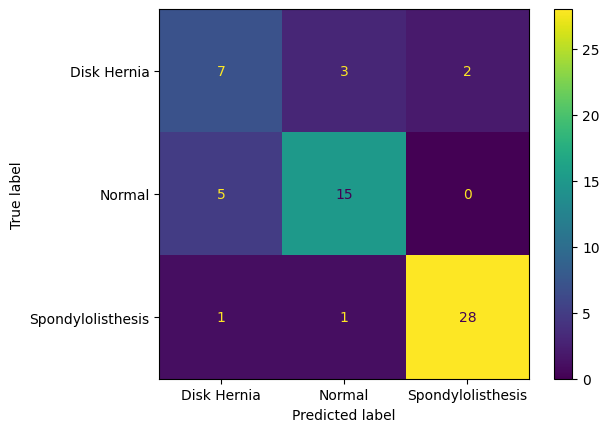

In [75]:
matriz_confusao = confusion_matrix(y_true = y_test,
                                   y_pred = y_predit,
                                   labels=['Disk Hernia', 'Normal', 'Spondylolisthesis'])

# plotando uma figura com a matriz de confusao
figure = plt.figure(figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao,
                              display_labels=['Disk Hernia', 'Normal', 'Spondylolisthesis'])
disp.plot(values_format='d')

In [76]:
print(classification_report(y_test, y_predit))

                   precision    recall  f1-score   support

      Disk Hernia       0.54      0.58      0.56        12
           Normal       0.79      0.75      0.77        20
Spondylolisthesis       0.93      0.93      0.93        30

         accuracy                           0.81        62
        macro avg       0.75      0.76      0.75        62
     weighted avg       0.81      0.81      0.81        62



Testando o KNN com validação cruzada:

Incluindo a etapa de validação do modelo de knn
Estamos fazendo a VALIDAÇÃO dos melhores hiperparâmetros do modelo de ML:

Idealmente, devemos ter 5 conjuntos de dados (treino, teste, validacao) ou usar a validação cruzada em cima dos dados de treino.



In [78]:
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) os dados.
result = cross_val_score(modelo_classificador, X, y, cv = kfold)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))

K-Fold (R^2) Scores: [0.79032258 0.80645161 0.79032258 0.82258065 0.78688525]
Mean R^2 for Cross-Validation K-Fold: 0.7993125330512956


A saída exibirá a precisão média do modelo (ou seja, a acurácia) com uma medida de variação associada (calculada pela multiplicação do desvio padrão por 2).

Escolhendo os melhores hiperparâmetros com validação cruzada:

In [80]:
error = [] #armazenar os erros

# Calculating error for K values between 1 and 15
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_scaled, y_train)
    pred_i = knn.predict(x_test_scaled)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

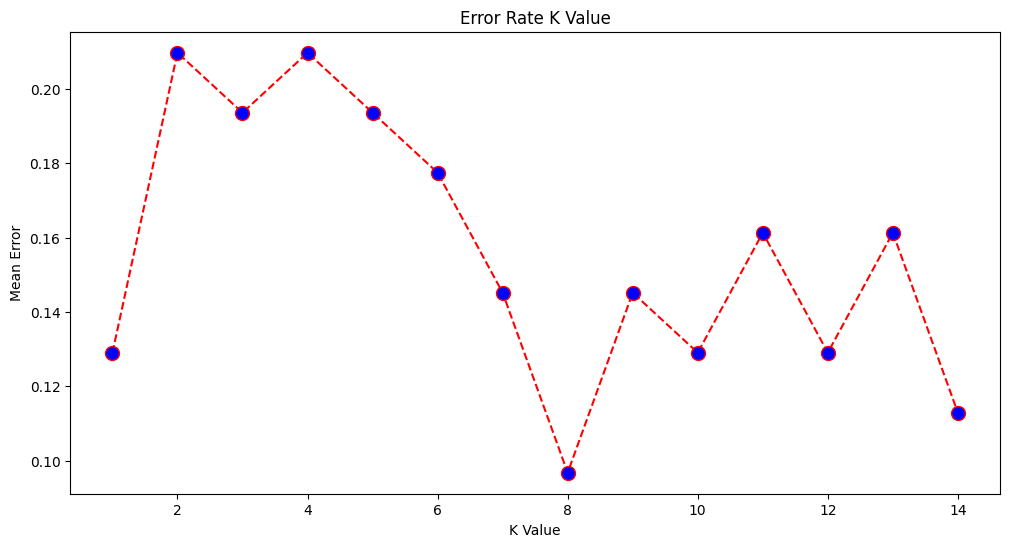

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [82]:
# Buscar os melhores parâmetros
# Vamos usar uma técnica chamada Gridsearch que é basicamente a busca por força bruta
# Iremos utilizar a técnica de validação cruzada de 5 folds (divisões) em cima do conjunto de treinamento
# Como métrica de melhor desemepnho usaremos a acurácia, isto é, estamos buscando os hiperparâmetros que maximizam a acurácia

# Parâmetros testados
param_grid = {'n_neighbors':[8,14], #total de vizinhos
              'weights': ['uniform', 'distance'], #Função de peso usada na previsão
              'metric':['cosine', 'euclidean', 'manhattan'] #métrica para cálculo da distância
             }

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3) #cv = gerador de validação cruzada / n_jobs = determina a quantidade de jobs processados

grid.fit(x_train_scaled, y_train) #Selecionando os melhores hiperparametros com base nos dados de treino
knn_params = grid.best_params_
print('KNN', knn_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}


In [85]:
grid.cv_results_ #analisando todos os possíveis testes

{'mean_fit_time': array([0.00539131, 0.00182452, 0.00330477, 0.0017139 , 0.003793  ,
        0.00666471, 0.00508695, 0.00195146, 0.00200763, 0.00439787,
        0.00386896, 0.00342269]),
 'std_fit_time': array([2.67200808e-03, 7.95824789e-05, 1.27354014e-03, 1.40363852e-04,
        2.84981102e-03, 4.05803175e-03, 3.86002314e-03, 8.99238270e-05,
        2.17209537e-04, 5.08571908e-03, 3.88035412e-03, 2.91541357e-03]),
 'mean_score_time': array([0.01809649, 0.00502038, 0.01758766, 0.0088037 , 0.01776929,
        0.0036376 , 0.01591549, 0.00908761, 0.02112694, 0.00304699,
        0.02006159, 0.00356617]),
 'std_score_time': array([0.00469648, 0.00255203, 0.00413895, 0.00432676, 0.00478394,
        0.0019375 , 0.00321836, 0.00501718, 0.00848312, 0.00080867,
        0.0059136 , 0.00156155]),
 'param_metric': masked_array(data=['cosine', 'cosine', 'cosine', 'cosine', 'euclidean',
                    'euclidean', 'euclidean', 'euclidean', 'manhattan',
                    'manhattan', 'manhatt

Testando vários tipos de algoritmos de classificação:

In [84]:
def AplicaValidacaoCruzada(x_axis, y_axis):
  # Linear Models.
  from sklearn.neighbors import KNeighborsClassifier  # k-vizinhos mais próximos (KNN)
  from sklearn.ensemble import RandomForestClassifier # RandomForest
  from sklearn.svm import SVC                         # Maquina de Vetor Suporte SVM

  # Cross-Validation models.
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import KFold

  # Configuração de KFold.
  kfold  = KFold(n_splits=10, shuffle=True)

  # Axis
  x = x_axis
  y = y_axis

  # Criando os modelos

  # KNN
  knn = KNeighborsClassifier(n_neighbors=8, metric= 'euclidean', weights='distance')
  knn.fit(x_train_scaled, y_train)

  # SVM
  svm = SVC()
  svm.fit(x_train_scaled, y_train)

  # RandomForest
  rf = RandomForestClassifier(random_state=7)
  rf.fit(x_train_scaled, y_train)

  # Applyes KFold to models.
  knn_result = cross_val_score(knn, x, y, cv = kfold)
  svm_result = cross_val_score(svm, x, y, cv = kfold)
  rf_result = cross_val_score(rf, x, y, cv = kfold)

  # Creates a dictionary to store Linear Models.
  dic_models = {
    "KNN": knn_result.mean(),
    "SVM": svm_result.mean(),
    "RF": rf_result.mean()
  }
  # Select the best model.
  melhorModelo = max(dic_models, key=dic_models.get)

  print("KNN (R^2): {0}\nSVM (R^2): {1}\nRandom Forest (R^2): {2}".format(knn_result.mean(), svm_result.mean(), rf_result.mean()))
  print("O melhor modelo é : {0} com o valor: {1}".format(melhorModelo, dic_models[melhorModelo]))

In [86]:
  AplicaValidacaoCruzada(X, y)

KNN (R^2): 0.8346236559139785
SVM (R^2): 0.8506451612903225
Random Forest (R^2): 0.8511827956989247
O melhor modelo é : RF com o valor: 0.8511827956989247
